## Seasonal NAO skill comparison ##

In the decadal predictions, we observe a pretty significant drop in skill post-2005 initiailisation. As the dataset is limited to around 50 years and we have only observed one 'forecast bust' like this, we don't know whether Doug was just lucky or whether something is actually going wrong in the models in the recent period.

To explore this, we consider the seasonal hindcasts:

1. CSF-20C (Coupled Seasonal Forecast):This is a hindcast performed with the model fully coupled to the Nucleus for European Modelling of the Ocean (NEMO) ocean model, initialised from CERA-20C reanalysis data.
2. ASF-20C (Atmospheric Seasonal Forecasts): This is a hindcast performed with prescribed Sea Surface Temperature (SST) and sea-ice boundary conditions at the surface, initialised form ERA-20C reanalysis data.

These both run from initialisation in 1901-2009, so give a longer time period.

Strommen et al. (2023) propose that seasonal forecasts can be used to diagnose decadal forecast signals over a longer period. We plan to look at this in the context of 8 year running mean (years 2-9 of the decadal forecast) NAO predictability. In doing this, we want to explore the following questions:

* Was the recent drop in NAO skill an outlier in the longer period (1901-2020)?
* Have similar 'forecast bust' periods been observed before?
* Are there similar conditions occuring during previous bust periods?
    * i.e. divergence of model/obs SPNA SSTs

In [1]:
# Import relevant modules
import os
import sys

# Third party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Testing dask again
import dask
import dask.array as da

# Import cdo for regridding
from cdo import Cdo
cdo = Cdo()

In [2]:
# Import local dictionaries and functions
sys.path.append('/home/users/benhutch/skill-maps')

# Import dictionaries
import dictionaries as dic

# Set up the path where the functions are stored
sys.path.append('/home/users/benhutch/skill-maps/python')

# Import functions
import functions as func

# Import the NAO skill functions
import nao_skill_functions as nao_func

# Set up the path where the functions are stored
sys.path.append('/home/users/benhutch/skill-maps/rose-suite-matching')

# Import the suite functions
import nao_matching_seasons as nms_func

# Import the bootstrapping functions
import process_bs_values as pbs_func

### Data access issues ###

* ERA20C reanalysis not easily accessible?
* Who should I contact to try to get access?
* Maybe just look back to 1940 onwards (ERA5 window) first

In [3]:
# Find some of the ASF20C data on jasmin
# Set up the parameters
model = "ASF20C" # Alternative is "CSF20C"
variable = "SLP" # Sea level pressure
initialisation = "Nov" # Month of initialisation
year = 1901 # First year of the hindcast
member=1 # Ensemble member
region="Global" # For regridding

# Set up the base path
base_path_20c = "/badc/deposited2020/seasonal-forecasts-20thc/data"

# Find the specific file
folder_name = f"{variable}monthly_{model}_{initialisation}START_ENSmems"

# Set up the file name
file_name = f"{variable}monthly_{year}_M{member}.nc"

# Set up the full path
file_path = os.path.join(base_path_20c, model,
                            folder_name, file_name)

# Check if the file exists
if os.path.exists(file_path):
    print(f"The file {file_path} exists")

# Set up directories in canari to store the regridded psl data
# Set up the base path
base_path = "/gws/nopw/j04/canari/users/benhutch"

# Form a new path
new_path_ASF20C = os.path.join(base_path, "seasonal",
                               "ASF20C", variable,
                                 f"{initialisation}_START")

# Same for the CSF20C
new_path_CSF20C = os.path.join(base_path, "seasonal",
                               "CSF20C", variable,
                                 f"{initialisation}_START")

# Check if the directories exist
if not os.path.exists(new_path_ASF20C):
    print(f"The directory {new_path_ASF20C} exists")
    # Create a new directory
    os.makedirs(new_path_ASF20C, exist_ok=False)

# Same for the CSF20C
if not os.path.exists(new_path_CSF20C):
    print(f"The directory {new_path_CSF20C} exists")
    # Create a new directory
    os.makedirs(new_path_CSF20C, exist_ok=False)

The file /badc/deposited2020/seasonal-forecasts-20thc/data/ASF20C/SLPmonthly_ASF20C_NovSTART_ENSmems/SLPmonthly_1901_M1.nc exists


In [4]:
# Find the gridspec for the file
gridspec_dir = "/home/users/benhutch/gridspec/"

# # Print all of the files within the directory
# print(os.listdir(gridspec_dir))

# Find gridspec-global.txt
gridspec_file = os.path.join(gridspec_dir, "gridspec-global.txt")

# Print the contents of the file
print(open(gridspec_file).read())

gridtype=lonlat
xfirst=-180
xinc=2.5
xsize=144
yfirst=-90
yinc=2.5
ysize=72


In [5]:
# Find the directory where all of the data to be regridded is stored
dir = os.path.join(base_path_20c, model,
                            folder_name)

# # Print all of the files within the directory
# print(os.listdir(dir))

# # Find the files within the directory
# files = os.listdir(dir)

# # Limit files to the first 10
# files = files[:10]

# # Loop through the files
# for file in files:
#     # Set up the output file name
#     output_file = os.path.join(new_path_ASF20C, f"{file[:-3]}_rg.nc")

#     # If the output file already exists, skip
#     if os.path.exists(output_file):
#         print(f"The file {output_file} exists")
#         continue

#     # Set up the input file name
#     input_file = os.path.join(dir, file)

#     # perform the regridding
#     cdo.remapbil(gridspec_file, input=input_file,
#                  output=output_file)

### Time ###

The timesteps for the seasonal forecasts are set up in a weird way. We are going to assume that if the forecast is initialized on the 1st November and then run forwards for four months, then the first timestep is the November mean, the second December, then January and February. Therefore, to get the DJF mean, we will take the average of all time steps but the first.

In [6]:
#Import pandas
import pandas as pd

# # Find my directory with the regridded data
# # Print the files contained within new_path_ASF20C
# print(os.listdir(new_path_ASF20C))

# Create an array of initialisation years
years = np.arange(1901, 2011)

# For a single file, collapse this into a DJF mean
# First calculate the anomaly field
# Then calculate the DJF mean anomalies
# Then azores gridbox mean - iceland gridbox mean
# Do this for a single file first as a test
test_file = os.path.join(new_path_ASF20C, "SLPmonthly_1901_M1_rg.nc")

# Read in the file
ds = xr.open_dataset(test_file)

ds

# # Extract the lats and lons
lats = ds['lat']
lons = ds['lon']

# Generate an array of years from 1901 to 2009
years = np.arange(1901, 2010)

# Generate an array for the members from 1 to 50
members = np.arange(1, 51)

# Print the shape of the data
print(np.shape(lats))
print(np.shape(lons))
print(np.shape(years))
print(np.shape(members))

# Extract the data for the variable: 'MSL_GDS0_SFC'
data = ds['MSL_GDS0_SFC']

# Print the shape of the data
print(data.shape)

# Take the mean over the time dimension
djf_mean = data[1:, :, :].mean(axis=0)

# Print the shape of the data
print(djf_mean.shape)

# Print the data
print(djf_mean)

(72,)
(144,)
(109,)
(50,)
(4, 72, 144)
(72, 144)
<xarray.DataArray 'MSL_GDS0_SFC' (lat: 72, lon: 144)>
array([[100824.6 , 100824.6 , 100824.6 , ..., 100824.6 , 100824.6 ,
        100824.6 ],
       [100243.15, 100247.77, 100253.4 , ..., 100259.94, 100253.44,
        100247.77],
       [ 99846.35,  99874.48,  99851.52, ..., 100026.48,  99937.15,
         99880.23],
       ...,
       [102820.85, 102822.23, 102824.94, ..., 102804.94, 102813.23,
        102817.81],
       [102873.69, 102879.85, 102886.85, ..., 102854.85, 102861.85,
        102869.35],
       [102807.19, 102810.77, 102814.1 , ..., 102792.31, 102797.56,
        102802.48]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5


In [7]:
# Start the dask client
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46867,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:42372,Total threads: 4
Dashboard: http://127.0.0.1:34629/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:38050,


In [8]:
# Add additional workers
client.cluster.scale(10)

In [9]:
# Generate an array of years from 1901 to 2009
years = np.arange(1901, 2010)

# Create an empty Dask array to store the data
asf_psl_field = da.empty([len(years), len(members)])

# Print the shape of the array
print(asf_psl_field.shape)

# Extract the lats and lons for the NAO region
iceland_lat1, iceland_lat2 = (
    dic.iceland_grid_corrected["lat1"],
    dic.iceland_grid_corrected["lat2"],
)
iceland_lon1, iceland_lon2 = (
    dic.iceland_grid_corrected["lon1"],
    dic.iceland_grid_corrected["lon2"],
)

azores_lat1, azores_lat2 = (
    dic.azores_grid_corrected["lat1"],
    dic.azores_grid_corrected["lat2"],
)
azores_lon1, azores_lon2 = (
    dic.azores_grid_corrected["lon1"],
    dic.azores_grid_corrected["lon2"],
)


# Define a function to process a single year and member
def process_year_member(year, member):
    # Print the year and member
    print("Processing year: ", year, " member: ", member)

    # Set up the file name
    file_name = f"SLPmonthly_{year}_M{member}_rg.nc"

    # Set up the file path
    file_path = os.path.join(new_path_ASF20C, file_name)

    # Read in the file
    ds = xr.open_dataset(file_path, chunks={"time": 100, "lat": 100, "lon": 100})

    # Read in the climatology file
    clim_file = os.path.join(new_path_ASF20C, "climatology", "full-climatology.nc")

    # Read in the file
    clim = xr.open_dataset(clim_file, chunks={"time": 100, "lat": 100, "lon": 100})

    # Extract the data for the variable: 'MSL_GDS0_SFC'
    data = ds["MSL_GDS0_SFC"]
    climatology = clim["MSL_GDS0_SFC"]

    # Remove the first time step
    data = data[1:, :, :]

    # Take the mean over the time dimension
    climatology = climatology.mean(axis=0)

    # Take the mean over the time dimension
    data = data.mean(axis=0)

    # Calculate the anomaly field
    data_anom = data - climatology

    # Take the mean over the spatial dimension of the iceland gridbox
    iceland_mean = data_anom.sel(
        lat=slice(iceland_lat1, iceland_lat2), lon=slice(iceland_lon1, iceland_lon2)
    ).mean(axis=(0, 1))

    # Take the mean over the spatial dimension of the azores gridbox
    azores_mean = data_anom.sel(
        lat=slice(azores_lat1, azores_lat2), lon=slice(azores_lon1, azores_lon2)
    ).mean(axis=(0, 1))

    # Calculate the NAO index
    nao_index = azores_mean - iceland_mean

    # Print the shape of the data
    print("shape of djf_mean: ", nao_index.shape)
    print("value of djf_mean: ", nao_index.values)

    # Return the Dask array
    return nao_index


# Create an empty list to store the results
results = []

# Loop through the years and members
# for year in years:
#     print("Processing year: ", year)

# # Set the year
# year = years[0]

# years_test = years[:5]

for year in years:
    print("Processing year: ", year)
    # Test the function
    for member in members:
        print("Processing member: ", member)

        # Use dask.delayed to delay the function and append the result to the list
        result = dask.delayed(process_year_member)(year, member)
        results.append(result)

# Print the results
print(results)

(109, 50)
Processing year:  1901
Processing member:  1
Processing member:  2
Processing member:  3
Processing member:  4
Processing member:  5
Processing member:  6
Processing member:  7
Processing member:  8
Processing member:  9
Processing member:  10
Processing member:  11
Processing member:  12
Processing member:  13
Processing member:  14
Processing member:  15
Processing member:  16
Processing member:  17
Processing member:  18
Processing member:  19
Processing member:  20
Processing member:  21
Processing member:  22
Processing member:  23
Processing member:  24
Processing member:  25
Processing member:  26
Processing member:  27
Processing member:  28
Processing member:  29
Processing member:  30
Processing member:  31
Processing member:  32
Processing member:  33
Processing member:  34
Processing member:  35
Processing member:  36
Processing member:  37
Processing member:  38
Processing member:  39
Processing member:  40
Processing member:  41
Processing member:  42
Processing

In [ ]:
# Start the Dask computation
asf_psl_field_results = dask.compute(*results)

# Print the results
print(type(asf_psl_field_results))

# # Print the shape of the results
# print(asf_psl_field_results.shape)

# Print the results
print(asf_psl_field_results)

# Create a test dask array
test_dask_array = da.empty([len(years), len(members)])

# Print the shape of the array
print(test_dask_array.shape)

member_counter = 0
year_counter = 0

# Loop through the results
for i, result in enumerate(asf_psl_field_results):
    # Print the shape of the result
    print(f"result {i} has value: ", result)

    # Set the value of the dask array
    test_dask_array[year_counter, member_counter] = result

    # Increment the counters
    member_counter += 1

    # If the member counter is equal to the number of members
    if member_counter == len(members):
        # Reset the member counter
        member_counter = 0

        # Increment the year counter
        year_counter += 1

# Print the dask array shape
print(test_dask_array.shape)

Processing year:  Processing year:  1908  member: 2003 28
Processing year:   Processing year:  1988  member:  1920 member: 46
  member:   7
1


2024-01-04 11:20:43,188 - distributed.nanny - WARNING - Restarting worker


Processing year:  1977 Processing year:  1946  member:  Processing year: 45
 1938 member:  16
Processing year:    member:  1909  member: 23
 46
Processing year:  Processing year:  1918 1921 member:   10 member: 
 Processing year: 24Processing year:   2007  member: 1977  member: 
  47
12
Processing year:  Processing year: 1982 2003  member:  Processing year:  1965  member:   member: Processing year: 42 10
 
1905  14
 member:  11
Processing year:  1943Processing year:  1983   member:  27
 member: Processing year:   112009  member:  Processing year: 5
 
1969  member:  46
Processing year:  1925Processing year:  1934  member:    member: Processing year: 22
  1914  member:  3040

Processing year:  1953  member:  3
Processing year: Processing year:   1905Processing year:  1901  1984  member:   member: 4 
21
Processing year:  member:   201966 
 member:  43
Processing year: Processing year:   1988 1971  member:   member:  46
12
Processing year:  1920  member:  7
Processing year:  1908  member: 

2024-01-04 11:21:03,202 - distributed.nanny - WARNING - Worker process still alive after 3.1999925231933597 seconds, killing


Processing year:  1990  member:  17


2024-01-04 11:21:03,835 - distributed.nanny - ERROR - Error in Nanny killing Worker subprocess
Traceback (most recent call last):
  File "/opt/jaspy/lib/python3.10/asyncio/tasks.py", line 418, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/jaspy/lib/python3.10/site-packages/distributed/nanny.py", line 597, in close
    await self.kill(timeout=timeout, reason=reason)
  File "/opt/jaspy/lib/python3.10/site-packages/distributed/nanny.py", line 380, in kill
    await self.process.kill(reason=reason, timeout=0.8 * (deadline - time()))
  File "/opt/jaspy/lib/python3.10/site-packages/distributed/nanny.py", line 853, in kill
    await process.join(max(0, deadline - time()))
  File "/opt/jaspy/lib/python3.10/site-packages/distributed/process.py", line 330, in join
    await wait_for(asyncio.shield(self._exit_future), timeout)
  File "/opt/jaspy/lib/python

shape of djf_mean:  ()
value of djf_mean:  746.91016
shape of djf_mean:  ()
shape of djf_mean:  ()
value of djf_mean:  254.4323
shape of djf_mean:  ()
shape of djf_mean:  ()
shape of djf_mean:  ()
value of djf_mean:  1430.8762
value of djf_mean:  -507.64288
value of djf_mean:  -1564.335
value of djf_mean:  1415.541
value of djf_mean: value of djf_mean:  -503.9925
 290.8112
value of djf_mean:  -820.5918
value of djf_mean:  107.809235
value of djf_mean:  81.59277
value of djf_mean:  867.5257
value of djf_mean:  147.1211
value of djf_mean:  -483.13605
value of djf_mean:  482.6123
value of djf_mean:  value of djf_mean:  798.0078
146.15884
value of djf_mean:  -1187.3588
value of djf_mean:  590.11395
value of djf_mean:  1412.6853
value of djf_mean:  765.7077
value of djf_mean:  -644.5638
value of djf_mean:  1588.0703
value of djf_mean:  -745.65784
value of djf_mean:  -665.5964
value of djf_mean:  1268.3635
value of djf_mean:  -517.9873
Processing year: Processing year:  1921 Processing year:

In [ ]:
test_dask_array

In [ ]:
# # TODO: We want to take the 8 year running mean of this array
# # Print the dask array
# print(test_dask_array.compute())

In [ ]:
# Extract the data
asf20c_nao = test_dask_array.compute()

In [14]:
print(asf20c_nao.shape)

# Create an empty array to store the results
asf20c_nao_rm = np.empty([len(years) - 7, len(members)])

# Set up the window
window = np.ones(8) / 8

# Loop through the members
for member in members:
    # Loop through the years
    for year in years[:-7]:
        # Set the year index
        year_index = year - 1901

        # Set the member index
        member_index = member - 1

        # Set the data
        data = asf20c_nao[year_index : year_index + 8, member_index]

        # Compute the 8 year running mean
        asf20c_nao_rm[year_index, member_index] = np.convolve(data, window, mode="valid")

# Forward running mean of the data
# from 1901 to 2010 - 7
# from 1901 to 2003
rm_years_asf20c = years[:-7]

# Print the shape of the data
print(asf20c_nao_rm.shape)
print(rm_years_asf20c.shape)

# Print the data
print(asf20c_nao)

(109, 50)
(102, 50)
(102,)
[[-1528.01599121   -69.77832031 -1487.66113281 ...  -239.04067993
  -1174.47436523    14.56477928]
 [  333.49966431  -551.34277344   618.56085205 ...  -673.24902344
   -469.92449951   832.94372559]
 [ -445.51922607   -87.08236694   -86.64877319 ...  -201.67254639
    273.86260986   424.83465576]
 ...
 [ -107.10481262  -489.47949219   -29.06381226 ...   267.47491455
    197.81933594 -1270.49731445]
 [  735.36486816   865.99414062  -906.84863281 ...   877.98797607
    452.72036743  -305.16210938]
 [-1045.35583496   139.72331238 -1813.19702148 ...   335.52700806
   -316.64746094  1070.78186035]]


In [15]:
# Import local dictionaries and functions
sys.path.append('/home/users/benhutch/skill-maps')

# Import dictionaries
import dictionaries as dic

# Set up the path where the functions are stored
sys.path.append('/home/users/benhutch/skill-maps/python')

# Import functions
import functions as func

# Import the NAO skill functions
import nao_skill_functions as nao_func

# Set up the path where the functions are stored
sys.path.append('/home/users/benhutch/skill-maps/rose-suite-matching')

# Import the suite functions
import nao_matching_seasons as nms_func

# Import the bootstrapping functions
import process_bs_values as pbs_func

In [16]:
# Find the psl field data
# Set up the base path
base_path_canari = "/gws/nopw/j04/canari/users/benhutch"

# File name
file_name = "adaptor.mars.internal-1703255460.0952423-14259-18-80988a8a-51a2-4138-9b16-41a188e1c9d8.grib"

# Form a new path
new_path_ERA5 = os.path.join(base_path_canari, "ERA5", file_name)

# Check if the file exists
if os.path.exists(new_path_ERA5):
    print(f"The file {new_path_ERA5} exists")

# Setup a directory for the regridded data
regrid_dir = os.path.join(base_path_canari, "ERA5", "regrid")

# Check if the directory exists
if not os.path.exists(regrid_dir):
    print(f"The directory {regrid_dir} does not exist")
    # Create a new directory
    os.makedirs(regrid_dir, exist_ok=False)

# Set up the output file name
output_file = os.path.join(regrid_dir, f"{file_name[:-5]}_rg.grib")

# # Print the output file name
# print(output_file)

# Set up the gridspec file
gridspec_file = os.path.join(gridspec_dir, "gridspec-global.txt")

# Check if the file exists
if os.path.exists(gridspec_file):
    print(f"The file {gridspec_file} exists")

# Only if the output file does not exist
if not os.path.exists(output_file):
    print(f"The file {output_file} does not exist")

    # Regrid the file
    cdo.remapbil(gridspec_file, input=new_path_ERA5, output=output_file)

# Find the file ending with _rg.nc in the regrid directory
# List the files in the directory
print(os.listdir(regrid_dir))

# Find the file ending with _rg.nc
files = os.listdir(regrid_dir)

# Loop through the files
psl_obs = [file for file in files if file.endswith("_rg.nc")]

# Print the files
print(psl_obs)

# Form the full path
psl_obs = os.path.join(regrid_dir, psl_obs[0])

# Extract using xarray
psl_obs = xr.open_dataset(
    psl_obs, chunks={"time": 100, "lat": 100, "lon": 100}
)

# Extract the months of December, January and February
psl_obs_djf = psl_obs.sel(time=psl_obs["time.season"] == "DJF")

# Calculate the mean over the time dimension - the climatology
psl_obs_djf_mean = psl_obs_djf.mean(dim="time")

# Remove the mean from the data
psl_obs_djf_anom = psl_obs_djf - psl_obs_djf_mean

# psl_obs_djf_anom

# Shift the time back by -2 and take the annual mean
# to get the annual DJF mean
psl_obs_djf_anom = psl_obs_djf_anom.shift(time=-2).resample(time="Y").mean(dim="time")

# Now take the rolling mean over 8 years
psl_obs_djf_anom = psl_obs_djf_anom.rolling(time=8, center=True).mean()

# Calculate the NAO index
# Extract the lats and lons for the NAO region
iceland_lat1, iceland_lat2 = (
    dic.iceland_grid_corrected["lat1"],
    dic.iceland_grid_corrected["lat2"],
)
iceland_lon1, iceland_lon2 = (
    dic.iceland_grid_corrected["lon1"],
    dic.iceland_grid_corrected["lon2"],
)

# And for the azores
azores_lat1, azores_lat2 = (
    dic.azores_grid_corrected["lat1"],
    dic.azores_grid_corrected["lat2"],
)
azores_lon1, azores_lon2 = (
    dic.azores_grid_corrected["lon1"],
    dic.azores_grid_corrected["lon2"],
)

# Take the mean over the spatial dimension of the iceland gridbox
iceland_mean = (
    psl_obs_djf_anom["var151"]
    .sel(
        lat=slice(iceland_lat1, iceland_lat2),
        lon=slice(iceland_lon1, iceland_lon2),
    )
    .mean(axis=(1, 2))
)

# Take the mean over the spatial dimension of the azores gridbox
azores_mean = (
    psl_obs_djf_anom["var151"]
    .sel(
        lat=slice(azores_lat1, azores_lat2),
        lon=slice(azores_lon1, azores_lon2),
    )
    .mean(axis=(1, 2))
)

# Calculate the NAO index
nao_index = azores_mean - iceland_mean

# Print the shape of the data
print("shape of nao_index: ", nao_index.shape)

# Print the data
print(nao_index)

The file /gws/nopw/j04/canari/users/benhutch/ERA5/adaptor.mars.internal-1703255460.0952423-14259-18-80988a8a-51a2-4138-9b16-41a188e1c9d8.grib exists
The file /home/users/benhutch/gridspec/gridspec-global.txt exists
['adaptor.mars.internal-1703255460.0952423-14259-18-80988a8a-51a2-4138-9b16-41a188e1c9d8_rg.grib', 'adaptor.mars.internal-1703255460.0952423-14259-18-80988a8a-51a2-4138-9b16-41a188e1c9d8_rg.nc']
['adaptor.mars.internal-1703255460.0952423-14259-18-80988a8a-51a2-4138-9b16-41a188e1c9d8_rg.nc']


shape of nao_index:  (84,)
<xarray.DataArray 'var151' (time: 84)>
dask.array<sub, shape=(84,), dtype=float64, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1940-12-31 1941-12-31 ... 2023-12-31


## DCPP ##

We also want to load the DCPP data as a comparison. We'll do this below and plot against the long ERA5 obs for comparison.

In [17]:
# Set up the arguments for extracting the DCPP model data
psl_models = dic.models
obs_path_psl = dic.obs
base_dir = dic.base_dir
plots_dir = "/gws/nopw/j04/canari/users/benhutch/plots/NAO_skill"
save_dir = dic.save_dir
global_grid = dic.gridspec_global
psl_var_name = "psl"

In [18]:
# Process the global psl anomalies to be used for the NAO index
obs_psl_anom_short = func.read_obs(variable='psl',
                            region='global',
                            forecast_range='2-9',
                            season="DJFM",
                            observations_path=obs_path_psl,
                            start_year=1960,
                            end_year=2023)

Time dimension of obs: ['1960-12-31T00:00:00.000000000' '1961-12-31T00:00:00.000000000'
 '1962-12-31T00:00:00.000000000' '1963-12-31T00:00:00.000000000'
 '1964-12-31T00:00:00.000000000' '1965-12-31T00:00:00.000000000'
 '1966-12-31T00:00:00.000000000' '1967-12-31T00:00:00.000000000'
 '1968-12-31T00:00:00.000000000' '1969-12-31T00:00:00.000000000'
 '1970-12-31T00:00:00.000000000' '1971-12-31T00:00:00.000000000'
 '1972-12-31T00:00:00.000000000' '1973-12-31T00:00:00.000000000'
 '1974-12-31T00:00:00.000000000' '1975-12-31T00:00:00.000000000'
 '1976-12-31T00:00:00.000000000' '1977-12-31T00:00:00.000000000'
 '1978-12-31T00:00:00.000000000' '1979-12-31T00:00:00.000000000'
 '1980-12-31T00:00:00.000000000' '1981-12-31T00:00:00.000000000'
 '1982-12-31T00:00:00.000000000' '1983-12-31T00:00:00.000000000'
 '1984-12-31T00:00:00.000000000' '1985-12-31T00:00:00.000000000'
 '1986-12-31T00:00:00.000000000' '1987-12-31T00:00:00.000000000'
 '1988-12-31T00:00:00.000000000' '1989-12-31T00:00:00.000000000'
 '

/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/iris/coords.py:2220: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


In [19]:
# Load and process the model psl anomalies for the NAO index
model_datasets_psl = func.load_data(base_directory=base_dir,
                                    models=psl_models,
                                    variable=psl_var_name,
                                    region='global',
                                    forecast_range='2-9',
                                    season='DJFM')

# Process the model psl anomalies
model_psl_anoms, _ = func.process_data(datasets_by_model=model_datasets_psl,
                                       variable=psl_var_name)

In [20]:
# Remove the years containing Nans from the short obs and model datasets
obs_psl_anom_short, \
model_psl_anoms, _ = func.remove_years_with_nans_nao(observed_data=obs_psl_anom_short,
                                                  model_data=model_psl_anoms,
                                                  models=psl_models,
                                                  NAO_matched=False)

No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN values in the model data
No NaN v

In [21]:
# Calculate the NAO stats
# test the new function
nao_stats_dict = nao_func.nao_stats(obs_psl=obs_psl_anom_short,
                        hindcast_psl=model_psl_anoms,
                        models_list=psl_models,
                        lag=4,
                        short_period=(1965, 2010),
                        season="DJFM")

Setting up the NAO stats for the BCC-CSM2-MR model
model number: 0
The years in the observations are not the same as the years in the hindcast data for the BCC-CSM2-MR model
Obs first year: 1965
Hindcast first year: 1966
Obs last year: 2019
Hindcast last year: 2019
years checking complete for the observations and the BCC-CSM2-MR model
years_short: [1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979
 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010]


nao_members shape: (8, 54)
nao_members_short shape: (8, 45)
nao_member shape: (54,)
nao_member_short shape: (45,)
nao_members shape: (8, 54)
nao_members_short shape: (8, 45)
nao_member shape: (54,)
nao_member_short shape: (45,)
nao_members shape: (8, 54)
nao_members_short shape: (8, 45)
nao_member shape: (54,)
nao_member_short shape: (45,)
nao_members shape: (8, 54)
nao_members_short shape: (8, 45)
nao_member shape: (54,)
nao_member_short shape: (45,)
nao_members shape: (8, 54)
nao_members_short shape: (8, 45)
nao_member shape: (54,)
nao_member_short shape: (45,)
nao_members shape: (8, 54)
nao_members_short shape: (8, 45)
nao_member shape: (54,)
nao_member_short shape: (45,)
nao_members shape: (8, 54)
nao_members_short shape: (8, 45)
nao_member shape: (54,)
nao_member_short shape: (45,)
nao_members shape: (8, 54)
nao_members_short shape: (8, 45)
nao_member shape: (54,)
nao_member_short shape: (45,)
NAO index calculated for the BCC-CSM2-MR model
Setting up the NAO stats for the MPI-ESM1

ValueError: setting an array element with a sequence.

In [ ]:
# Now we need to process the individual model data
# into a multi-model mean
# Just use the raw ensemble here (~178 members)
total_nens = 0

# Set up the length of the time series for raw and lagged
nyears_short = len(np.arange(1966, 2010 + 1))
nyears_long = len(np.arange(1966, 2019 + 1))

# Set up the years
years = nao_stats_dict['BCC-CSM2-MR']['years']

# Loop through the models
for model in psl_models:
    # Extract the NAO stats for the model
    nao_stats = nao_stats_dict[model]

    # Add the number of ensemble members for this model to the total
    total_nens += nao_stats['nens']

# Create an empty array to store the ensemble members
nao_members=np.zeros([total_nens, nyears_long])

# Set up the current index
current_index = 0

# Extract the members for the raw NAO index
for model in psl_models:
    nao_stats_model = nao_stats_dict[model]

    # Loop over the members
    for i in range(nao_stats_model['nens']):
        # Extract the NAO index for this members
        nao_member = nao_stats_model['model_nao_ts_members'][i, :]

        # Set up the length of the correct time series
        nyears_BCC = len(nao_stats_dict['BCC-CSM2-MR']['years'])

        # if the model is not BCC-CSM2-MR
        if model != 'BCC-CSM2-MR':
            # Extract the length of the time series for this model
            nyears = len(nao_stats_model['years'][1:])
        else:
            # Extract the length of the time series for this model
            nyears = len(nao_stats_model['years'])

        # if these lens are not equal then we need to skip over the 0th time index
        if nyears != nyears_BCC:
            print("The length of the time series for {} is not equal to the length of the time series for BCC-CSM2-MR".format(
                model))
            
            # Figure out how many years to skip over at the end
            skip_years = nyears_BCC - nyears
            
            # Assert that the new len is correct
            assert len(nao_member[1:skip_years]) == nyears_BCC, "Length of nao_member is not equal to nyears_BCC"
        else:
            # # Assert that the new len is correct
            # assert len(nao_member) == nyears_BCC, "Length of nao_member is not equal to nyears_BCC"

            # Set skip_years to length of time series
            skip_years = len(nao_member)

        # If the model is not BCC-CSM2-MR
        # then we need to skip over the 0th time index
        if model != "BCC-CSM2-MR":
            # Append this member to the array
            nao_members[current_index, :] = nao_member[1:skip_years]
        else:
            # Append this member to the array
            nao_members[current_index, :] = nao_member

        # Increment the counter
        current_index += 1

# Print the shape of the array
print(nao_members.shape)

print(nyears_BCC)

# Print the years
print(years)

print(nao_members)

# Calculate the multi-model mean
nao_mean = np.mean(nao_members, axis=0)

(178, 54)
54
[1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979
 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]
[[-165.98828125   -6.11132812  330.74188232 ...  -27.24771881
  -159.99316406  -55.70540619]
 [ -91.21744537 -530.79785156   70.3971405  ... -243.76855469
   265.15917969  140.12045288]
 [ -45.57551956  157.032547    -85.90136719 ...  521.45703125
   337.81219482  104.02506256]
 ...
 [-160.66862488  463.37826538  367.8359375  ...  262.81671143
   150.89779663  -61.83235931]
 [ 194.46452332  -15.61914062  169.36555481 ...  122.71614838
  -363.14907837 -398.18292236]
 [  89.94824219   52.7265625    46.06607819 ...  -90.68489075
  -314.24414062  -32.69628906]]


(84,)
(84,)
(54,)
(54,)


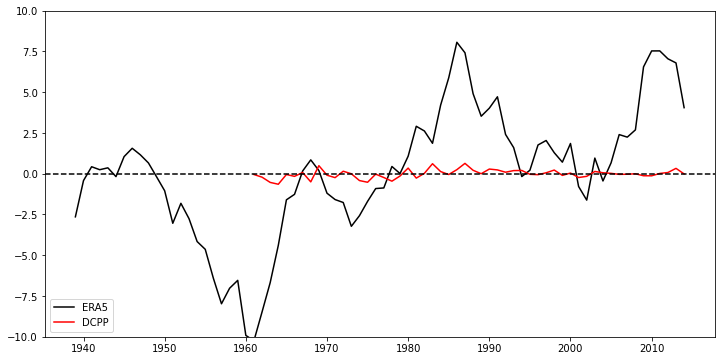

In [ ]:
# Plot both the long obs and the shorter DCPP data
long_nao_obs = nao_index

# Extract the years
long_nao_obs_years = long_nao_obs['time.year']

# Convert long_nao_obs and long_nao_obs_years to numpy arrays
long_nao_obs = long_nao_obs.values
long_nao_obs_years = long_nao_obs_years.values

# Print the shape of the data
print(long_nao_obs.shape)
print(long_nao_obs_years.shape)

# set the dcpp nao index
dcpp_nao_index = nao_mean

# Set the years for dcpp
dcpp_years = years

# Set up the ASF20C years
asf20c_years = rm_years_asf20c

# Set up the ASF20C NAO index
asf20c_nao_index = asf20c_nao_rm

# Print the shape of the data
print(dcpp_nao_index.shape)
print(dcpp_years.shape)

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the long obs
ax.plot(long_nao_obs_years - 5,
        long_nao_obs / 100, color='k', label='ERA5')

# Plot the DCPP
ax.plot(dcpp_years - 5,
        dcpp_nao_index / 100, color='r', label='DCPP')

# Plot the ASF20C - don't need to shift the years as takes a forward running mean
ax.plot(asf20c_years,
        asf20c_nao_index / 100, color='b', label='ASF20C')

# Set the x and y limits
ax.set_ylim([-10, 10])

# Set a horizontal line at zero
ax.axhline(y=0, color='k', linestyle='--')

# Set the legend in the lower left
ax.legend(loc='lower left')